In [50]:
import re
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity

In [51]:
def sentence_splitter():
    with open("../content.txt", "r") as file:
        content = file.read()
        sentences = re.split(r"(?<=[.!?])\s+", content)
    return sentences

In [52]:
sentences = sentence_splitter()
initial_chunks = [{"index": i, "chunk": sentence} for i, sentence in enumerate(sentences)]
initial_chunks

[{'index': 0,
  'chunk': 'Retrieval-Augmented Generation (RAG) is a groundbreaking technique in natural language processing that combines the strengths of retrieval-based and generative models to create a system capable of producing highly accurate and contextually relevant text.'},
 {'index': 1,
  'chunk': 'By leveraging both retrieval and generation, RAG models address many of the limitations of traditional models, offering a more robust and flexible approach to various tasks.'},
 {'index': 2,
  'chunk': 'The process begins with the retrieval of relevant documents or passages from a large corpus.'},
 {'index': 3,
  'chunk': 'The retrieval component typically uses dense embeddings, which are vector representations learned to capture the semantic meaning of the text.'},
 {'index': 4,
  'chunk': 'These embeddings allow the model to measure the similarity between the input query and potential documents, even when they do not share exact keywords.'},
 {'index': 5,
  'chunk': 'Dense retrie

In [53]:
def calculate_embeddings(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors = "pt", truncation = True, padding = True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim = 1).squeeze().numpy()

In [54]:
model_name = "BAAI/bge-small-en-v1.5"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [55]:
for i in range(len(initial_chunks)):
    embedding = calculate_embeddings(initial_chunks[i]["chunk"], model, tokenizer)
    initial_chunks[i]["embedding"] = embedding

In [56]:
def calculate_cosine_distances(initial_chunks):
    distances = []
    for i in range(len(initial_chunks) - 1):
        cur_embedding = initial_chunks[i]["embedding"]
        next_embedding = initial_chunks[i + 1]["embedding"]

        similarity = cosine_similarity([cur_embedding], [next_embedding])[0][0]
        distance = 1 - similarity

        distances.append(distance)
        initial_chunks[i]["distance_to_next"] = distance
        
    return distances

In [57]:
distances = calculate_cosine_distances(initial_chunks)

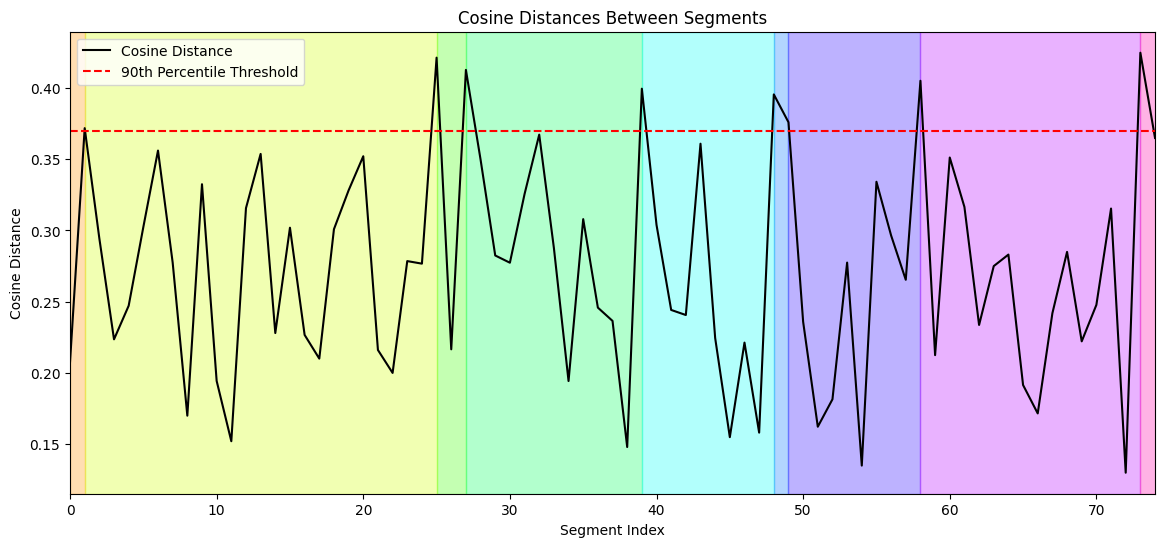

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def visualize_cosine_distances_with_thresholds_multicolored(
    cosine_distances, 
    threshold_percentile=90
):
    threshold_value = np.percentile(cosine_distances, threshold_percentile)

    crossing_points = [0]  
    crossing_points += [i for i, distance in enumerate(cosine_distances) if distance > threshold_value]
    crossing_points.append(len(cosine_distances))  

    plt.figure(figsize=(14, 6)) 

    sns.lineplot(
        x=range(len(cosine_distances)),
        y=cosine_distances,
        color="black",
        label="Cosine Distance",
    )

    plt.axhline(
        y=threshold_value,
        color="red",
        linestyle="--",
        label=f"{threshold_percentile}th Percentile Threshold",
    )

    colors = sns.color_palette("hsv", len(crossing_points) - 1)  
    for i in range(len(crossing_points) - 1):
        plt.axvspan(crossing_points[i], crossing_points[i + 1], color=colors[i], alpha=0.3)

    plt.title("Cosine Distances Between Segments")
    plt.xlabel("Segment Index")
    plt.ylabel("Cosine Distance")
    plt.legend()

    plt.xlim(0, len(cosine_distances) - 1)

    plt.show()

    return crossing_points

crossing_points = visualize_cosine_distances_with_thresholds_multicolored(distances)

In [59]:
threshold_percentile = 90
threshold_value = np.percentile(distances, threshold_percentile)

crossing_points = [0]
crossing_points += [i for i, distance in enumerate(distances) if distance > threshold_value]
len(crossing_points)

9

In [60]:
crossing_points

[0, 1, 25, 27, 39, 48, 49, 58, 73]

In [61]:
final_chunks = []

for point in range(len(crossing_points) - 1):
    current_chunk = ""
    for i in range(crossing_points[point], crossing_points[point + 1]):
        current_chunk += initial_chunks[i]["chunk"] + " "
    final_chunks.append(current_chunk)

In [62]:
final_chunks

['Retrieval-Augmented Generation (RAG) is a groundbreaking technique in natural language processing that combines the strengths of retrieval-based and generative models to create a system capable of producing highly accurate and contextually relevant text. ',
 'By leveraging both retrieval and generation, RAG models address many of the limitations of traditional models, offering a more robust and flexible approach to various tasks. The process begins with the retrieval of relevant documents or passages from a large corpus. The retrieval component typically uses dense embeddings, which are vector representations learned to capture the semantic meaning of the text. These embeddings allow the model to measure the similarity between the input query and potential documents, even when they do not share exact keywords. Dense retrieval models, often based on transformer architectures like BERT, excel at finding contextually relevant information. Once the most relevant documents are retrieved, 

In [63]:
def calculate_similarity(embedding1, embedding2):
    similarity = cosine_similarity([embedding1], [embedding2])
    return similarity[0][0]

In [79]:
def test_with_model(chunks, user_query, top_k, model_name = "BAAI/bge-small-en-v1.5"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    embeddings = []
    for i in range(len(chunks)):
        embedding = calculate_embeddings(chunks[i], model, tokenizer)
        embeddings.append(embedding)
        
    user_query_embedding = calculate_embeddings(user_query, model, tokenizer)
    scores = {i: calculate_similarity(user_query_embedding, embedding) for i, embedding in enumerate(embeddings)}
    sorted_chunks = sorted(scores.items(), key = lambda item: item[1], reverse = True)[:top_k]
    
    print("Matching chunks:\n")
    for chunk in sorted_chunks:
        print(chunks[chunk[0]], "\n")

In [80]:
test_with_model(final_chunks, user_query="What is rag?", top_k=1)

Matching chunks:

Retrieval-Augmented Generation (RAG) is a groundbreaking technique in natural language processing that combines the strengths of retrieval-based and generative models to create a system capable of producing highly accurate and contextually relevant text.  

